In [2]:

import pandas as pd
import numpy as np

from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  f1_score, recall_score, precision_score, confusion_matrix

from pprint import pprint
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import *

# Homemade functions required
from data_prep_functions import *

In [3]:
############# EDIT, FILL IN DATA HERE ############
data_file = 'Mass Spec and Protein Properties 200CMNP.xlsx'  # needs xlsx at the end

CMNP200_prop_sheet = 'Protein Properties'
CMNP200_mass_spec_sheet = 'Mass Spec Details'

netsurfp_data = pd.read_excel("data/"+'netsurfp_2_CMNP2000_processed.xlsx')
###################################################
############ NO EDITS REQUIRED ##############
data_filepath = "data/"+data_file
# load data

CMNP200_raw_prop_data = pd.read_excel(data_filepath, sheet_name= CMNP200_prop_sheet, thousands=',')
CMNP200_raw_mass_spec_data = pd.read_excel(data_filepath, sheet_name=CMNP200_mass_spec_sheet, header=0)

#clean up and calculate % protein abundance and enrichment

CMNP200_mass_spec_data_clean = clean_up_data_mass_spec(CMNP200_raw_mass_spec_data)
Accesions_IDs = CMNP200_mass_spec_data_clean["Accession"].to_frame()

# clean up data protein data

CMNP200_cleaned_data = clean_up_data_biopy(CMNP200_raw_prop_data, Accesions_IDs)

CMNP200_cleaned_data = normalize_mass_length_1DF(CMNP200_cleaned_data)

CMNP200_complete_data = pd.merge(CMNP200_cleaned_data, netsurfp_data, left_on='Entry', right_on='entry')


for df in [CMNP200_complete_data]:
    for col in ['asa_sum']:
        df[col+'_normalized'] = df[col] / df['Mass']


/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/data_prep_functions.py:450: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_data = seq_data.append(temp_df)
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/data_prep_functions.py:450: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_data = seq_data.append(temp_df)
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/data_prep_functions.py:450: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_data = seq_data.append(temp_df)
/Users/gustavo/Pycha

In [4]:
trials = 100
first_frame = True
correctness_frame = pd.DataFrame()
metrics_frame = pd.DataFrame()

for thresh_power in np.arange(1,3.6,.25):
    print('Power ', thresh_power)
    fluids_type_list=['CMNP200']
    CMNP200_labels = CMNP200_mass_spec_data_clean[['Accession', 'NP_%_Abundance','Enrichment','FBS Relative Abundance']].copy()
    data_sheets = [CMNP200_labels]
    x = np.arange(0,1,.01)
    for k in range(1):
        sheet = data_sheets[k]
        fluid_type = fluids_type_list[k]

        print(f'\n{fluid_type.capitalize()} running')

        num_proteins = np.zeros(100)
        for i in np.arange(0,100,1):
            thresh = i/100
            index = (sheet['NP_%_Abundance']>thresh)
            num_proteins[i] = (np.count_nonzero(index))


        num_proteins_above_1_abundance = min(num_proteins)
        biexponent_dist = num_proteins - num_proteins_above_1_abundance
        num_protein_thresh = np.max(biexponent_dist)/pow(np.e,thresh_power)
        cutoff_thresh_value = min(x[(biexponent_dist<num_protein_thresh)&(biexponent_dist>0)], default=0)
        psudeo_enriched_proteins = sheet[sheet["FBS Relative Abundance"] < 0.044]
        non_psudeo_enriched_proteins = sheet[sheet["FBS Relative Abundance"] > 0.044]
        psudeo_enriched_proteins['Corona'] = (psudeo_enriched_proteins['NP_%_Abundance']>cutoff_thresh_value).astype(int)
        non_psudeo_enriched_proteins['Corona'] = ((non_psudeo_enriched_proteins['NP_%_Abundance']>cutoff_thresh_value) | (non_psudeo_enriched_proteins['Enrichment']>1)).astype(int)
        psudeo_enriched_prot_labels = psudeo_enriched_proteins[["Accession", "Corona"]]
        non_psudeo_enriched_pro_labels = non_psudeo_enriched_proteins[["Accession", "Corona"]]
        remerged_protein_labels = non_psudeo_enriched_pro_labels.append(psudeo_enriched_prot_labels, ignore_index=True)
        sheet = pd.merge(sheet,remerged_protein_labels, how="inner", on='Accession')
        print(sheet['Corona'].sum()/sheet['Corona'].shape[0])
        CMNP200_labels = sheet
    CMNP200_labels = CMNP200_labels.drop(['NP_%_Abundance', 'Enrichment', 'FBS Relative Abundance'], axis=1)



    # checks for any accession lists
    CMNP200_labels = accession_expansion(CMNP200_labels)


    CMNP200_total_data_names = pd.merge(CMNP200_labels, CMNP200_complete_data.copy(), left_on='Accession', right_on='Entry')

    CMNP200_total_data_names =CMNP200_total_data_names.drop(['Accession','Entry', 'entry', 'Sequence', 'Length', 'Mass'], axis=1)


    features_CMNP200 = CMNP200_total_data_names.copy()
    features_CMNP200 = features_CMNP200.drop(['Corona'], axis=1)
    names_CMNP200 = CMNP200_total_data_names['Corona'].copy()


    ### create a merged set
    # features_plasma_labeled = features_plasma.copy()
    # features_csf_labeled = features_csf.copy()
    #
    # features_plasma_labeled['phase_plasma'] = 1
    # features_csf_labeled['phase_plasma'] = 0
    #
    # features_merged = features_plasma_labeled.append(features_csf_labeled, ignore_index=True)
    # names_merged = names_plasma.append(names_csf, ignore_index=True)


    # set with no phase labeling names are identical to names merged
    #features_merged_naive = features_merged.drop(['phase_plasma'], axis=1)

    #rename database to match combined database name

    features_merged_naive = features_CMNP200
    names_merged = names_CMNP200
    
    scaler = MinMaxScaler()

    total_data = features_merged_naive.copy()
    total_data = total_data.fillna(0)
    total_data = total_data.drop(['Protein names'], axis=1)
    scaler = scaler.fit(total_data)
    scaled_df = pd.DataFrame(scaler.transform(total_data), columns=total_data.columns)

    names = names_merged.copy()
    


    df = scaled_df.copy()
    labels = names
    feature_imp = pd.DataFrame(columns=list(scaled_df.columns))

    i = 0
    sss = StratifiedShuffleSplit(n_splits=trials, test_size=0.1, random_state=2016)
    for train_index, test_index in sss.split(df, labels):
        X_train = df.iloc[train_index]
        X_test = df.iloc[test_index]
        y_train = labels.iloc[train_index]
        y_test = labels.iloc[test_index]
        k = i
        sme = SMOTE(sampling_strategy=0.8, random_state=i, n_jobs=-1, k_neighbors=12)
        X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train)

        # Create and Train
        rfc=RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=i, n_estimators=100)

        rfc.fit(X_train_oversampled,y_train_oversampled)
        if first_frame:  # Initialize 
            first_frame = False  # Don't Come back Here

            datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}

            correctness_frame = pd.DataFrame(data=datadict)
            correctness_frame['round'] = i

            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
            'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
            'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}

            metrics_frame = pd.DataFrame.from_dict(data=metrics_dict,orient='index').transpose()
            metrics_frame['round'] = i
            metrics_frame['Threshold Power'] = thresh_power


        else:
            datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
            revolve_frame = pd.DataFrame(data=datadict)
            revolve_frame['round'] = i
            correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)

            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
            'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
            'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
            metrics_revolve_frame = pd.DataFrame.from_dict(data=metrics_dict, orient='index').transpose()
            metrics_revolve_frame['round'] = i
            metrics_revolve_frame['Threshold Power'] = thresh_power
            
            metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
    

        i += 1


        feature_imp.loc[i] = pd.Series(rfc.feature_importances_,index=list(df.columns))



        

Power  1.0

Cmnp200 running
0.43564356435643564


/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psudeo_enriched_proteins['Corona'] = (psudeo_enriched_proteins['NP_%_Abundance']>cutoff_thresh_value).astype(int)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_psudeo_enriched_proteins['Corona'] = ((non_psudeo_enriched_proteins['NP_%_Abundance']>cutoff_thresh_value) | (non_psudeo_enriched_protei

Power  1.25

Cmnp200 running
0.38613861386138615


/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The fra

Power  1.5

Cmnp200 running
0.33663366336633666


/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  remerged_protein_labels = non_psudeo_enriched_pro_labels.append(psudeo_enriched_prot_labels, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/375895216

Power  1.75

Cmnp200 running
0.30198019801980197


/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The fra

Power  2.0

Cmnp200 running
0.2722772277227723


/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  remerged_protein_labels = non_psudeo_enriched_pro_labels.append(psudeo_enriched_prot_labels, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/375895216

Power  2.25

Cmnp200 running
0.2623762376237624


/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The fra

Power  2.5

Cmnp200 running
0.2376237623762376


/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The fra

Power  2.75

Cmnp200 running
0.23267326732673269


/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The fra

Power  3.0

Cmnp200 running
0.21782178217821782


/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The fra

Power  3.25

Cmnp200 running
0.20297029702970298


/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The fra

Power  3.5

Cmnp200 running
0.20297029702970298


/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
/var/folders/qv/2dzqg1z114x9bm15w0rr2vkh0000gn/T/ipykernel_19888/3758952165.py:137: FutureWarning: The fra

In [5]:
# save data with time, date and description
short_description = "RerunOfNewClassifer"

log_metrics_data(metrics_frame,short_description)


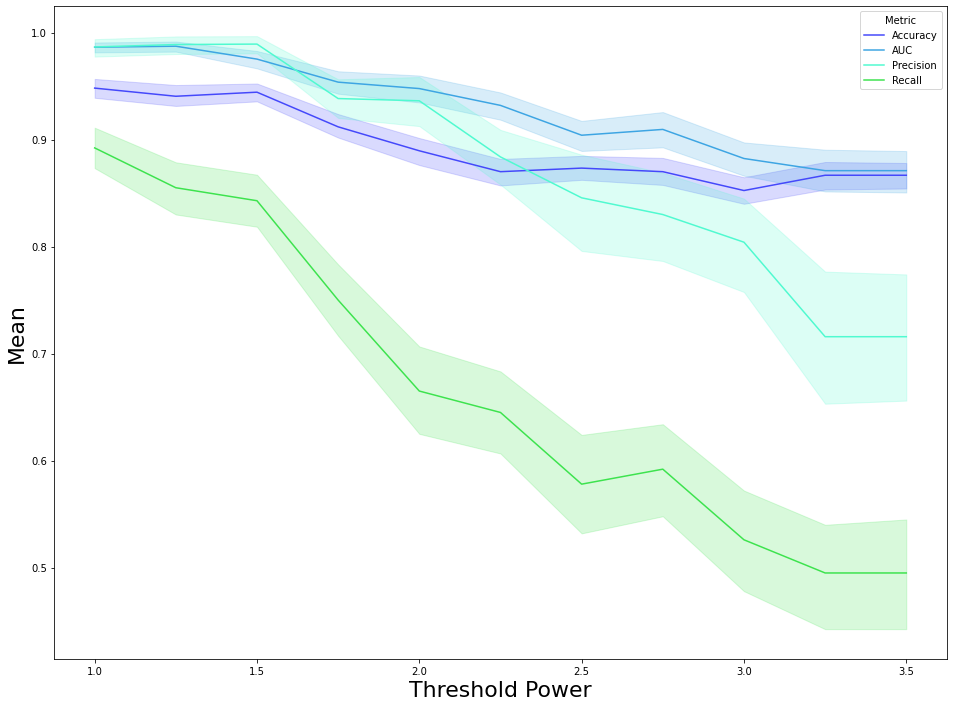

In [6]:
plt.rcParams.update({'font.size': 16})
total_metrics_df_melted = pd.melt(metrics_frame, id_vars=['Threshold Power', 'round'], value_vars=['Accuracy', 'AUC', 'Precision', 'Recall'],
                                  var_name='Metric', value_name='Mean')
# total_metrics_df_melted.head()
fig = plt.figure(figsize=(16,12))
ax = sns.lineplot(data=total_metrics_df_melted, x="Threshold Power", y="Mean", hue="Metric", palette=['#4448FB', '#3DA5E3', "#50FAD0", '#3DE34E'])

ax.set_ylabel('Mean', fontsize=22)
ax.set_xlabel('Threshold Power', fontsize=22)
# plt.savefig('Threshold_Power_Graph.svg', format='svg')
plt.show()